In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
SEQ_LEN = 40        # 입력 스퀀스 --> 슬라이딩 창의 길이
HIDDEN_SIZE = 64    # RNN 은닉상태의 차원
NUM_LAYERS = 1      # RNN 의 깊이
BATCH_SIZE = 64      # 학습 미니배치
NUM_EPOCHS = 120
LR = 1e-3

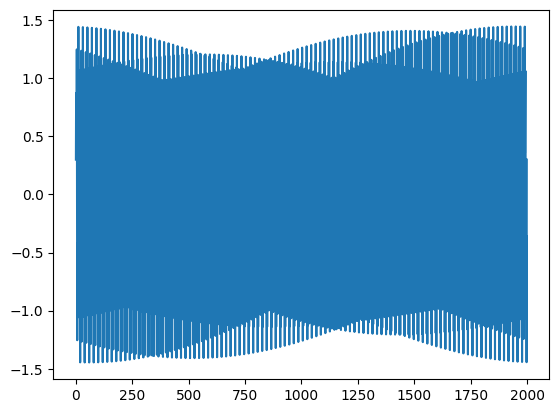

In [ ]:
t = np.linspace(0,200, 2000, dtype=np.float32) # 0~200 까지 2000의 샘플

signal = np.sin(2*np.pi * 1.0 * t)  # 1Hz 사인파
signal += 0.6 * np.sin(2*np.pi * 3.0 * t) # 3Hz 사인파 (진폭 0.6)
signal += 0.3 * np.cos(2*np.pi * 5.5 * t)
plt.plot(signal)


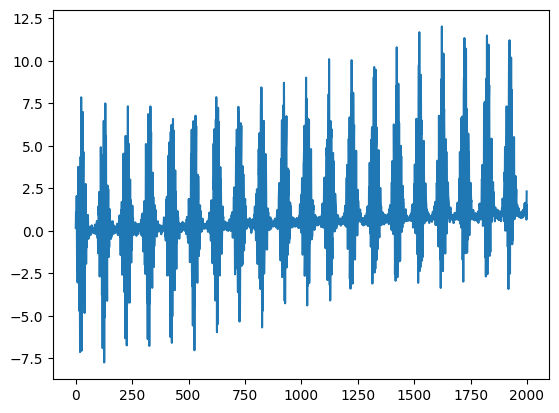

In [ ]:

amp_mod = 1.0 + 0.4 * np.sin(2*np.pi* 0.1 * t)
signal *= amp_mod
# plt.plot(signal)

signal += 0.002 * t # 상승 추세
# plt.plot(signal)

signal += 0.1 *np.random.randn(*t.shape) # 노이즈 추가
# plt.plot(signal)

data = signal[:, np.newaxis]
plt.plot(data)

In [ ]:
def make_seq(arr, seq_len):
    xs, ys = [], []
    for i in range(len(arr)-seq_len):  # 슬라이딩 윈도우
        xs.append(arr[i: i+seq_len])   # 입력 시퀀스
        ys.append(arr[i+seq_len])      # 시퀀스 다음 1개
    print(len(xs))
    print(len(xs[0]))

    print(len(ys))
    print(len(ys[0]))

    print(np.stack(xs).shape)
    print(np.stack(ys).shape)
    return np.stack(xs), np.stack(ys)

X, y = make_seq(data, SEQ_LEN)

1960
40
1960
1
(1960, 40, 1)
(1960, 1)


In [ ]:
# numpy --> pytorch.tensor --> dataloader
tensor_X = torch.from_numpy(X)
tensor_y = torch.from_numpy(y)

dataset = TensorDataset(tensor_X, tensor_y)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()

        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size) # 은닉층 --> 스칼라

    def forward(self, x):
        out,_ = self.rnn(x)  # (전체출력, h_n)
        # out, _= self.lstm(x)
        out = out[:, -1, :]  # 마지막 타임스텝의 은닉값
        out = self.fc(out)

        return out

In [ ]:
model = SimpleRNN(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [ ]:
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:

        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(dataset)
    if epoch % 10 ==0 or epoch ==1:
        print(f"Epoch {epoch:3d}/{NUM_EPOCHS}, Loss {epoch_loss:.4f}")


Epoch   1/120, Loss 4.8701
Epoch  10/120, Loss 0.9015
Epoch  20/120, Loss 0.5607
Epoch  30/120, Loss 0.3519
Epoch  40/120, Loss 0.2499
Epoch  50/120, Loss 0.2335
Epoch  60/120, Loss 0.2139
Epoch  70/120, Loss 0.2021
Epoch  80/120, Loss 0.1842
Epoch  90/120, Loss 0.1800
Epoch 100/120, Loss 0.1577
Epoch 110/120, Loss 0.1675
Epoch 120/120, Loss 0.1545


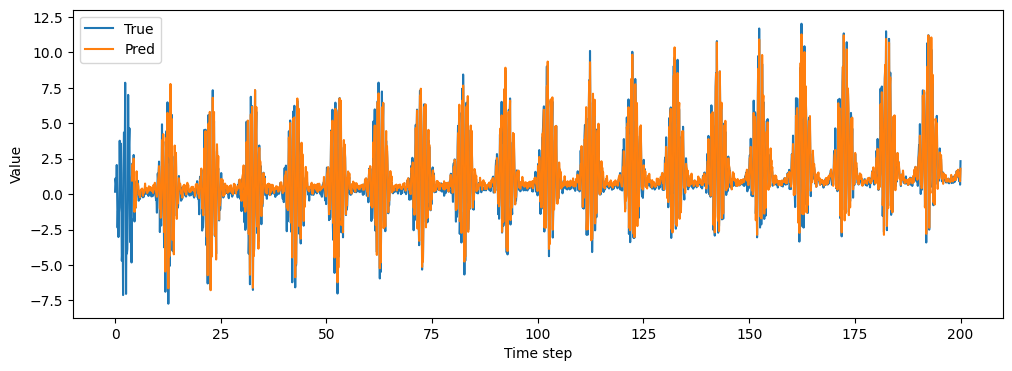

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(torch.from_numpy(X)).numpy()

plt.figure(figsize=(12,4))
plt.plot(t, data[:, 0], label ="True")
plt.plot(t[SEQ_LEN:], preds.squeeze(), label='Pred')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
!pip install -q sentence-transformers # Sentence-Transformers 패키지 설치

In [ ]:
import torch
from sentence_transformers import SentenceTransformer  # SBERT 모델
from sklearn.metrics.pairwise import cosine_similarity # 코사인 유사도

In [ ]:
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS') # 공개 한국어 SBERT 체크포인트

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentences = [
    "삼성동에서 근무하고 있습니다.",
    "삼성동에서 밥먹고 있습니다.",
    "삼성역 근처 맛집을 추천합니다.",
    "오늘 날씨가 매우 덥다.",
    "자연어 처리는 매우 흥미로운 분야이다."
    ]

In [ ]:
embeddings = model.encode(sentences)


In [ ]:
print(embeddings.shape)
print(type(embeddings))

(5, 768)
<class 'numpy.ndarray'>


In [ ]:
sim01 = cosine_similarity(
    [embeddings[0]],
    [embeddings[1]]
)[0][0]
print(f"문장 0-1 유사도 : {sim01:4f}")

문장 0-1 유사도 : 0.692981


In [ ]:
sim_matrix = cosine_similarity(embeddings, embeddings)
import pandas as pd
pd.DataFrame(sim_matrix,
             index=[f"S{i}" for i in range(len(sentences))],
             columns=[f"S{i}" for i in range(len(sentences))])

,S0,S1,S2,S3,S4
S0,1.000000,0.692981,0.290171,0.032675,0.143164
S1,0.692981,1.000000,0.340426,0.061965,0.112710
S2,0.290171,0.340426,1.000000,0.084626,0.222021
S3,0.032675,0.061965,0.084626,1.000000,0.113491
S4,0.143164,0.112710,0.222021,0.113491,1.000000


In [ ]:
# !pip install -q konlpy scikit-learn  # konlpy와 scikit-learn 설치

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 23.1 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt # Okt 형태소 분석기 임포트
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF 벡터화
from sklearn.metrics.pairwise import cosine_similarity # 코사인 유사도 계산

In [ ]:
okt = Okt()

In [ ]:
raw_corpus = [
    "나는 오늘도 모델을 공부한다",
    "자연어 처리는 정말 재미있다",
    "머신러닝 모델이 점점 좋아진다",
    "딥러닝은 데이터가 중요하다",
    "삼성동에는 맛있는 밥집이 많다",
    "강남역에서 친구를 만났다",
    "커피 한 잔이 기분을 좋게 한다",
    "스포츠는 건강에 도움이 된다",
    "영화를 보면 감성이 풍부해진다",
    "독서는 지식을 확장시킨다"
]

In [ ]:
# 형태소 분석 + 명사 추출
tokenized_corpus = []
for sentence in raw_corpus:
    tokens = okt.nouns(sentence)
    tokenized_corpus.append(" ".join(tokens))

for tokens in tokenized_corpus:
    print(tokens)

나 오늘 모델 공부
자연어 처리 정말
머신 러닝 모델 점점
딥 러닝 데이터
삼성동 밥집
강남역 친구
커피 잔 기분
스포츠 건강 도움
영화 감성
독서 지식 확장


In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tokenized_corpus)

print(f"TF-IDF 행렬 : {tfidf_matrix.shape}")

TF-IDF 행렬 : (10, 24)


In [ ]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

pd.DataFrame(cosine_sim_matrix)

,0,1,2,3,4,5,6,7,8,9
0,1.00000,0.0,0.235950,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.23595,0.0,1.000000,0.296632,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.296632,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
6,0.00000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
7,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
8,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
9,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
